## Initial data analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette("colorblind6")

# Path to the data
data_path = "./data/ClimateTrain.csv"

# Read as pandas dataframe and transform dates to datetime
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

# Plot description
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## Raw data

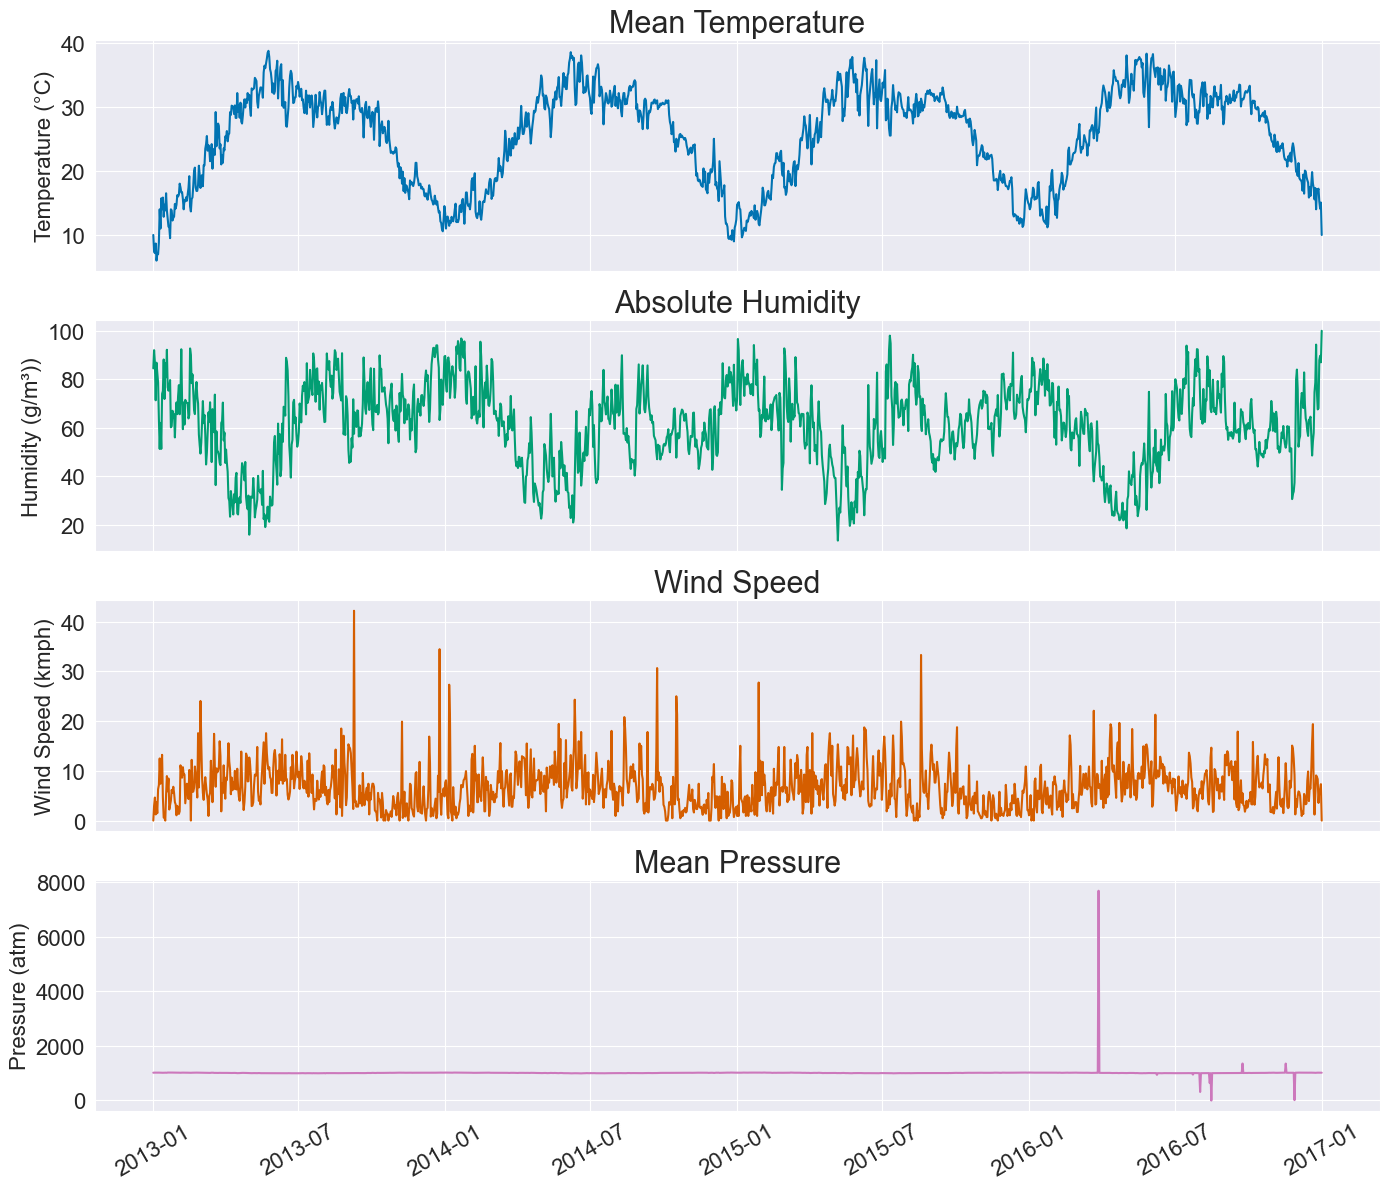

In [3]:
# Define labels etc.
titles = ["Mean Temperature", "Absolute Humidity", "Wind Speed", "Mean Pressure"]
ylabels = ["Temperature (°C)", "Humidity (g/m³))", "Wind Speed (kmph)", "Pressure (atm)"]

figure, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True) 

for idx, var in enumerate(df.columns[1:]):
    
    axes[idx].plot(df["date"], df[var], color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)

axes[3].tick_params(axis="x", rotation=30)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("./images/raw_data.pdf", format="pdf")
plt.show()

## Remove outliers


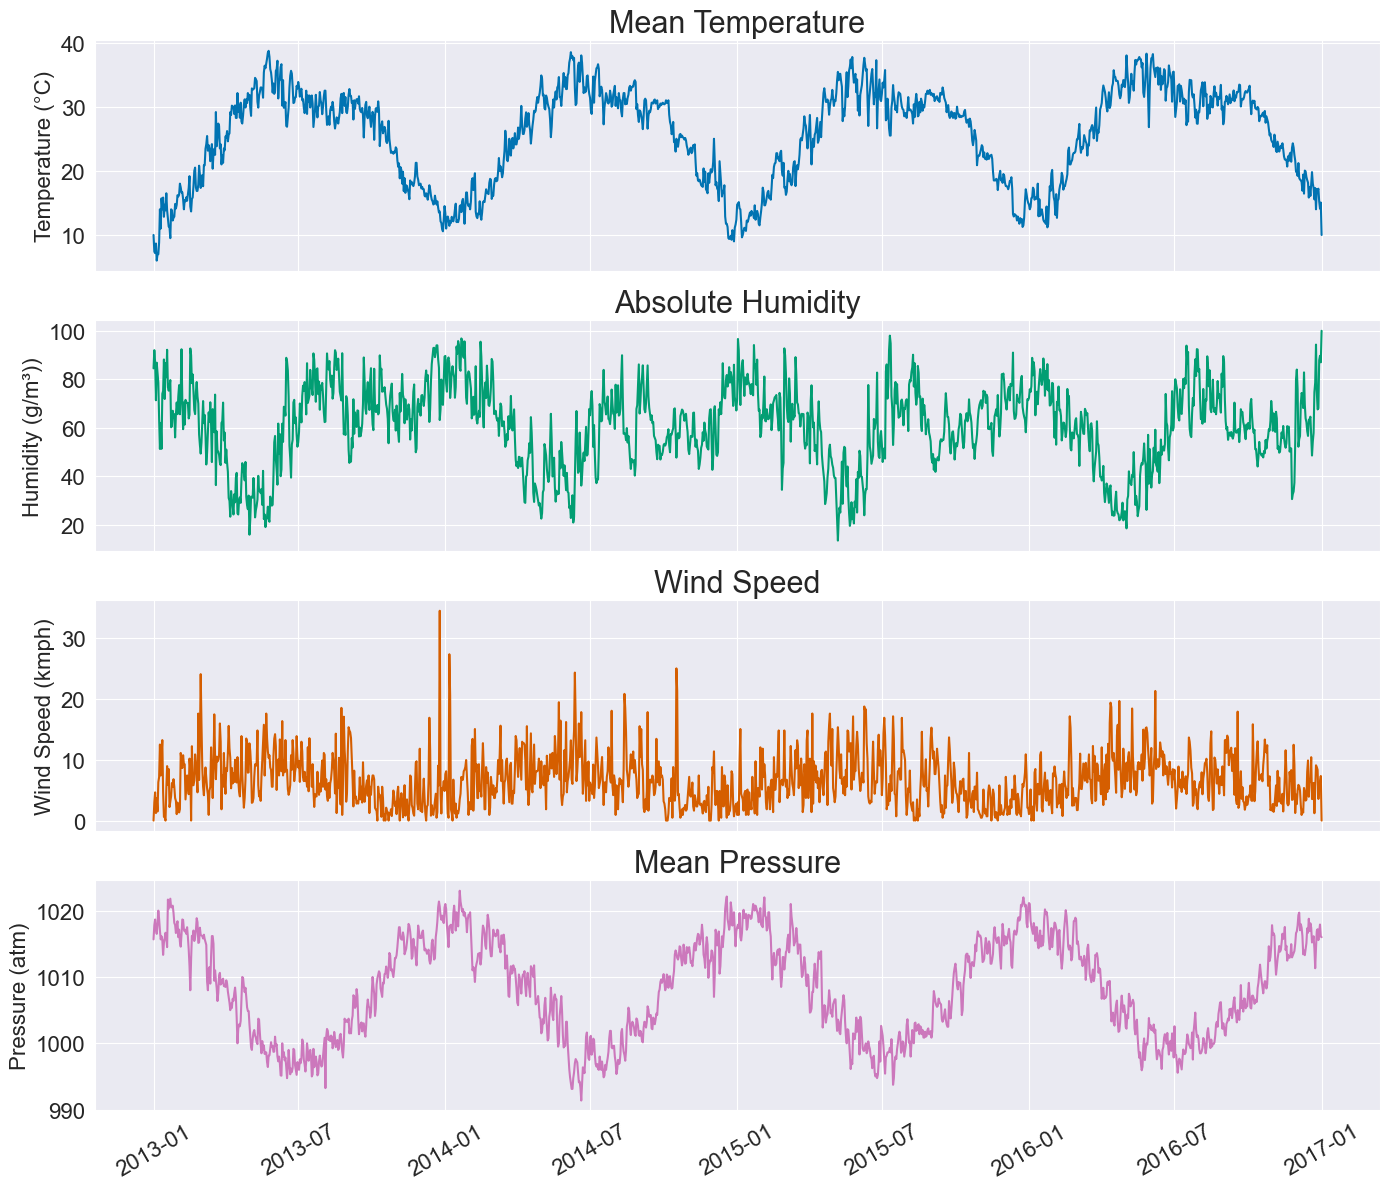

In [4]:
figure, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True) 

for idx, col in enumerate(df.columns[1:]):
    whole_period = df[col].dropna() # whole data
    normal_period = whole_period[: 2 * 365] # reference period (visually no major outliers here)
    
    roll = normal_period.rolling(window=30, min_periods=1, center=True) # Rolling window of 30 over the reference period
    roll_mean = roll.mean()
    roll_std = roll.std()

    mean = pd.concat([roll_mean, roll_mean.iloc[:1], roll_mean, roll_mean.iloc[:1]], ignore_index=True) # Repeat for almost the whole period
    std = pd.concat([roll_std, roll_std.iloc[:1], roll_std], ignore_index=True)

    z_score = (whole_period - mean) / std # Z-score based on the reference period

    out_bool = (z_score.abs() > 4) # Outliers are those with an absolute z-score greater than 3
    whole_period[out_bool] = mean[out_bool] # Replace outliers with the mean from the reference period

    axes[idx].plot(df["date"], whole_period, color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)
    df[col] = whole_period

axes[3].tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.savefig("./images/clean_data.pdf", format="pdf")
plt.show()

## Decomposition

In [5]:
decomps = []
period = 365 # Assumed seasonality
for col in df.columns[1:]:
    column = df[col]
    column.index = df['date'] 
    decomps.append(
        sm.tsa.seasonal_decompose(column, model="additive", period=period)
    )

## Trend

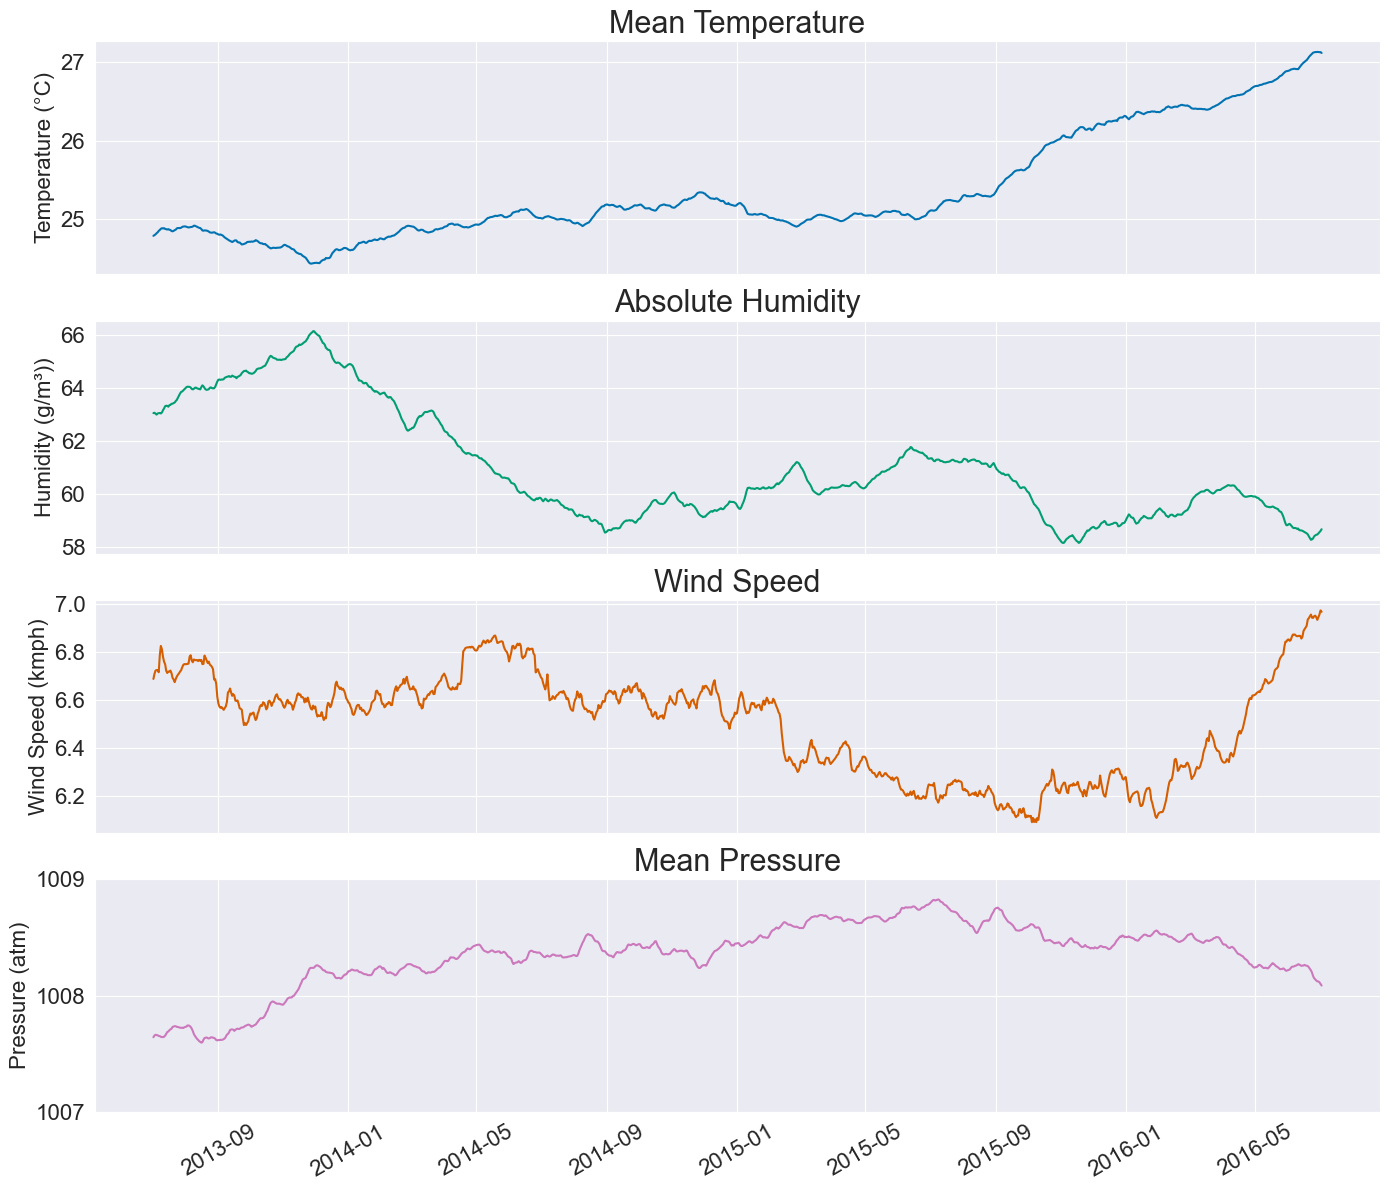

In [6]:
figure, axes = plt.subplots(len(decomps), 1, figsize=(14, 12), sharex=True)
for idx, decomposition in enumerate(decomps):
    axes[idx].plot(decomposition.trend, label='Trend', color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)

axes[3].tick_params(axis="x", rotation=30)
axes[3].set_yticks([1007, 1008, 1009])
# figure.suptitle(f"Trend of the data using a {period}-day periodical decomposition")
plt.tight_layout()
# plt.savefig(f"./images/trend{period}.pdf", format="pdf")
plt.show()

## Seasonality

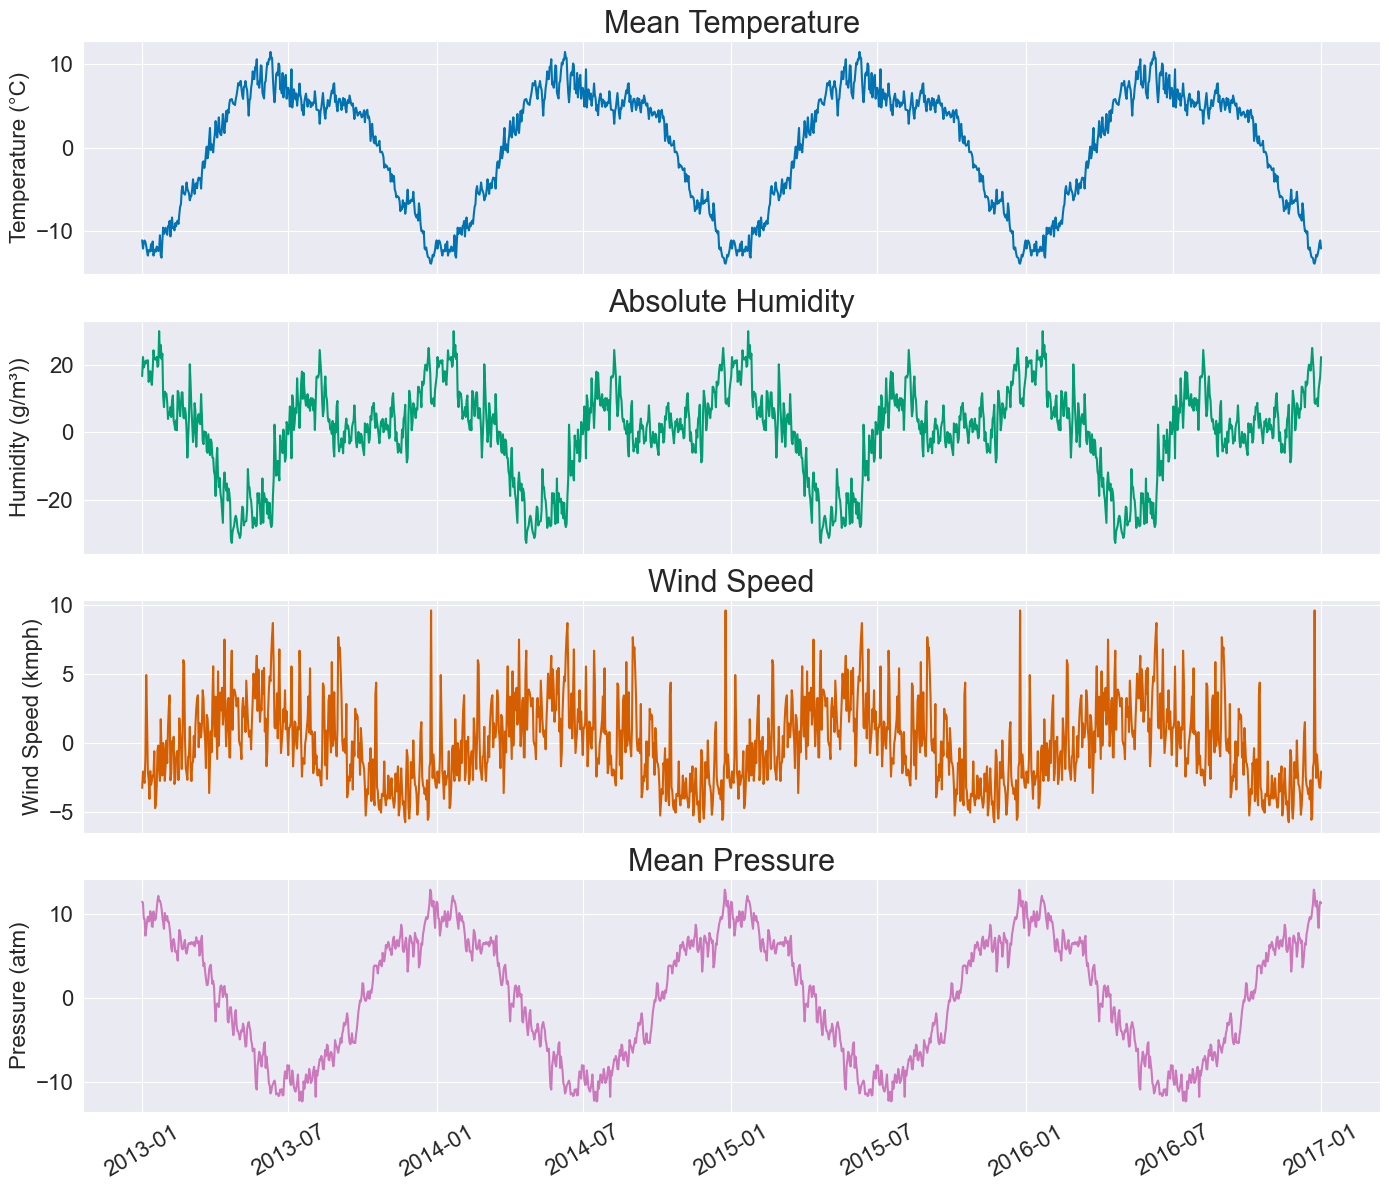

In [7]:
figure, axes = plt.subplots(len(decomps), 1, figsize=(14, 12), sharex=True)
for idx, decomposition in enumerate(decomps):
    seasonality = decomposition.seasonal
    axes[idx].plot(seasonality, label="Trend", color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)

axes[3].tick_params(axis="x", rotation=30)
    
# axes[-1].set_xlabel("Date")
# figure.suptitle(f"Seasonality of the data using a {period}-day periodical decomposition")
plt.tight_layout()
# plt.savefig(f"./images/seasonality{period}.pdf", format="pdf")
plt.show()

## Residuals

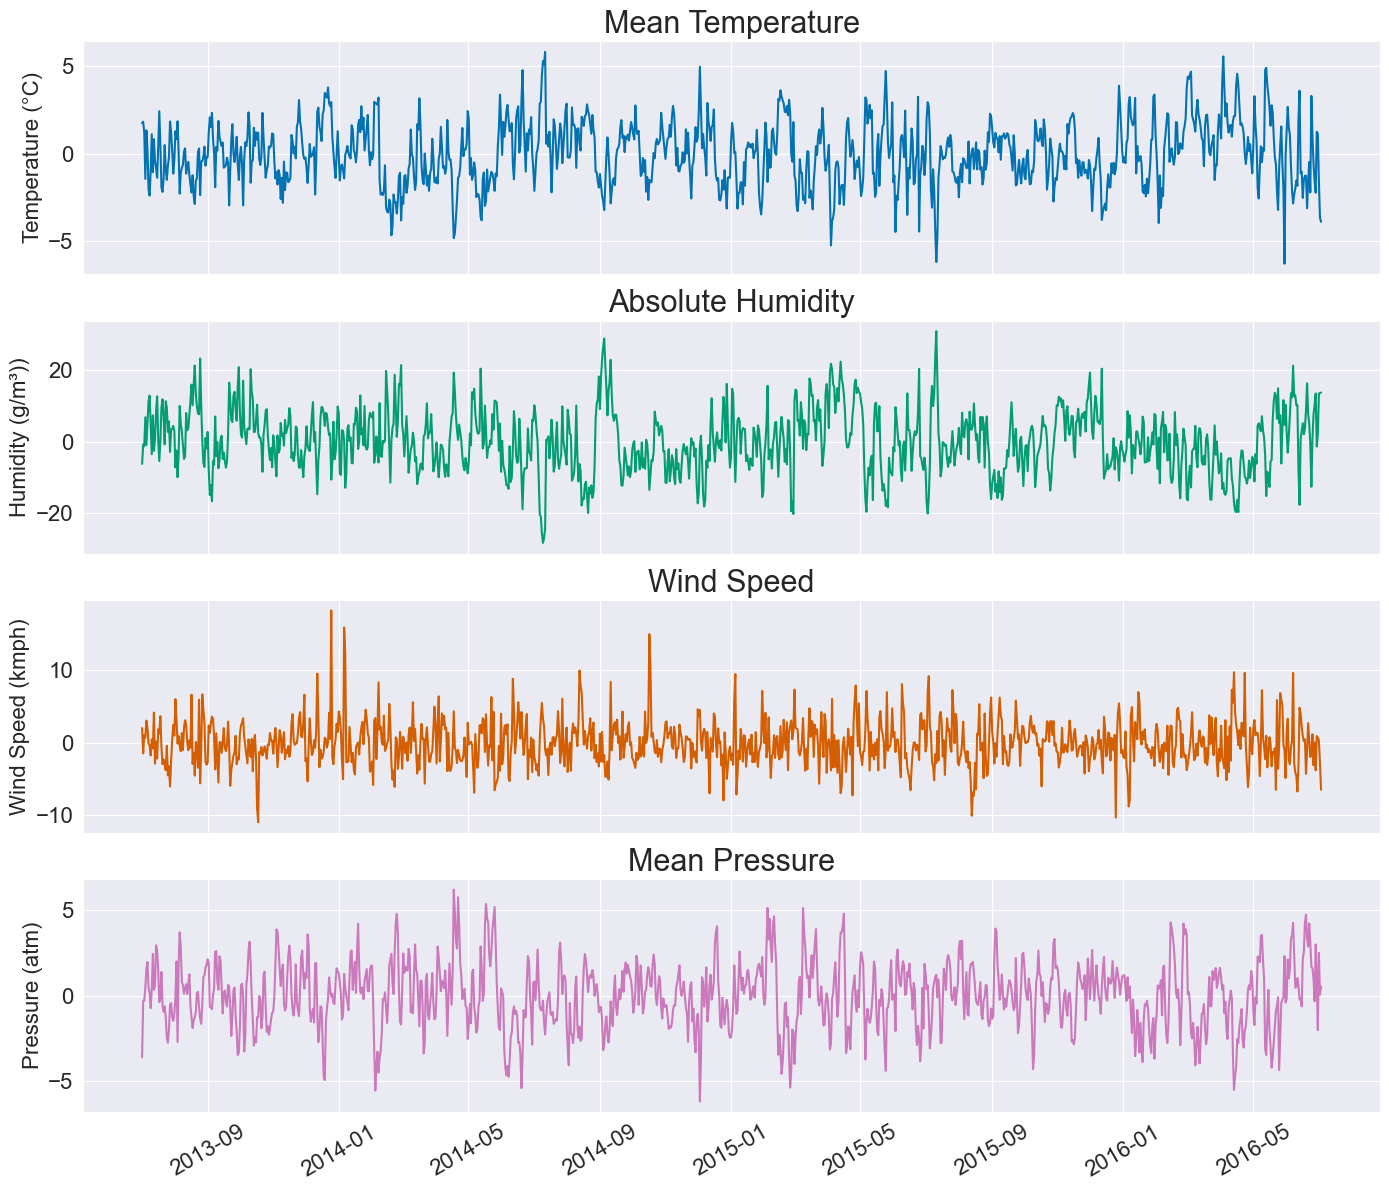

In [8]:
figure, axes = plt.subplots(len(decomps), 1, figsize=(14, 12), sharex=True)
for idx, decomposition in enumerate(decomps):
    axes[idx].plot(decomposition.resid, label="Trend", color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)

axes[3].tick_params(axis="x", rotation=30)
# axes[-1].set_xlabel("Date")
# figure.suptitle(f"Residuals of the data using a {period}-day periodical decomposition")
plt.tight_layout()
# plt.savefig(f"./images/residual{period}.pdf", format="pdf")
plt.show()

## Autocorrelation

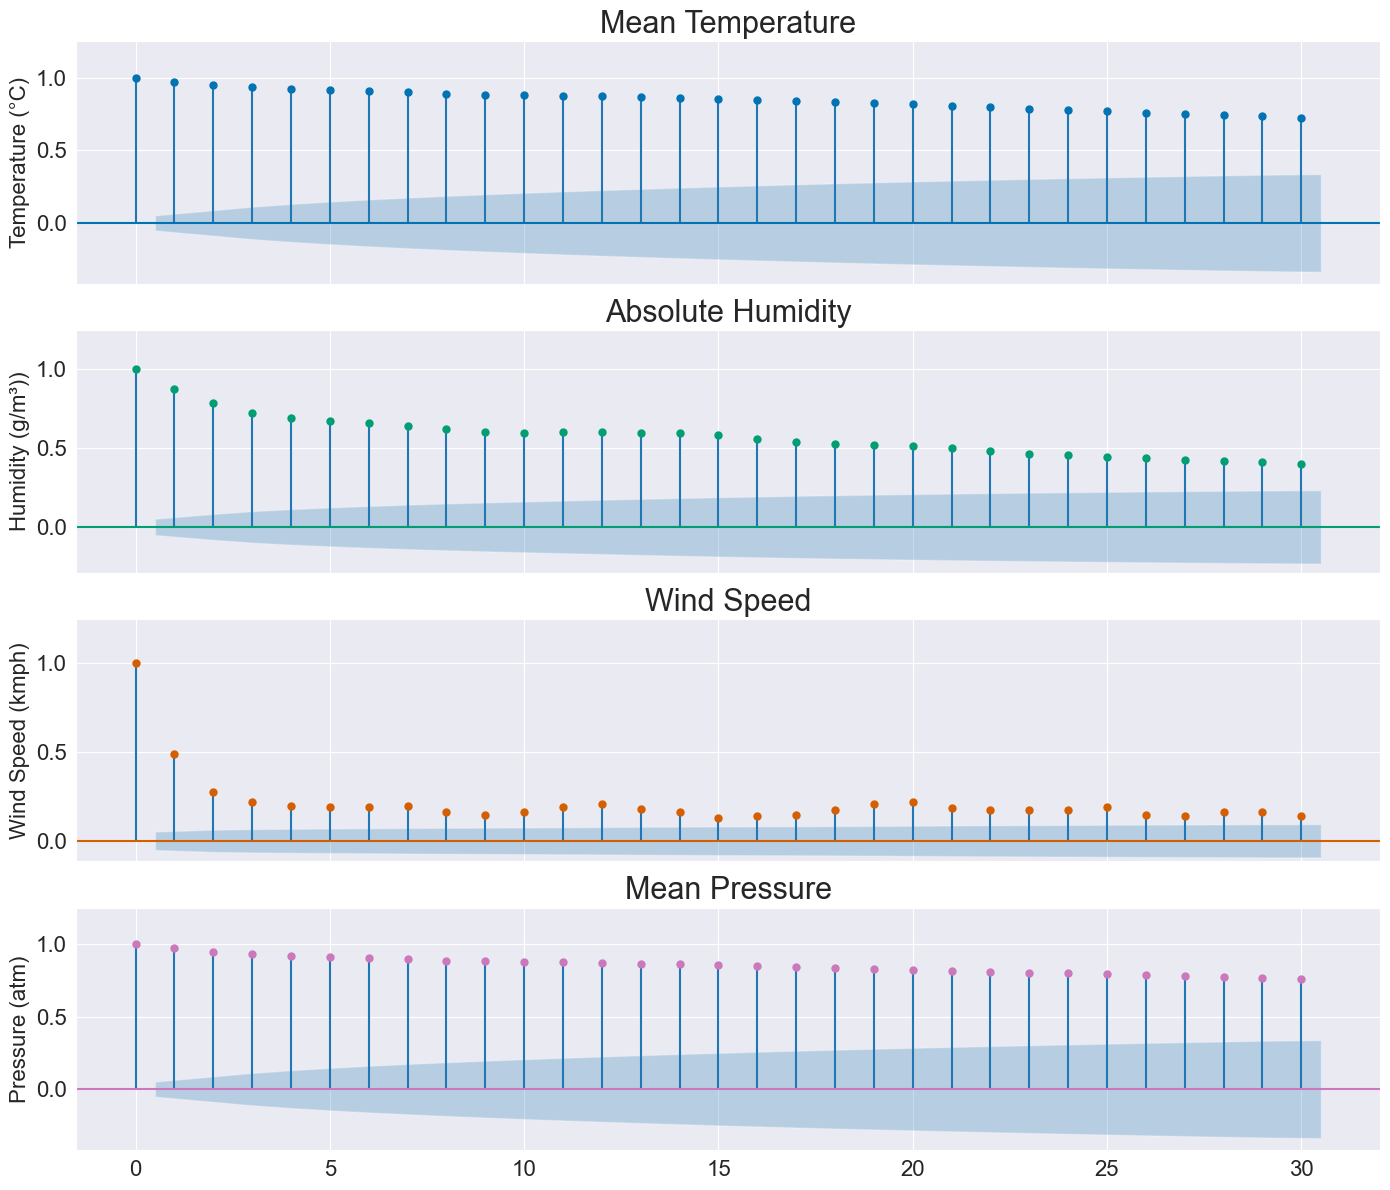

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

figure, axes = plt.subplots(4,1, figsize=(14, 12), sharex=True)  # 4 rows, 1 column
mlag = 30
for idx, col in enumerate(df.columns[1:]):
    plot_acf(df[col], ax=axes[idx], lags=mlag, color=colors[idx], title=None, auto_ylims=True)
    #axes[i].acorr(df[col], maxlags=mlag, color=colors[i], normed=True)
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)

# axes[3].tick_params(axis="x", rotation=30)
# figure.suptitle(f"Autocorrelation of the features ({mlag} lags)")
plt.tight_layout()
# plt.savefig(f"./images/autocorrelation{mlag}.pdf", format="pdf")
plt.show()

## Test decomposing to multiple parts

<Figure size 1400x1200 with 0 Axes>

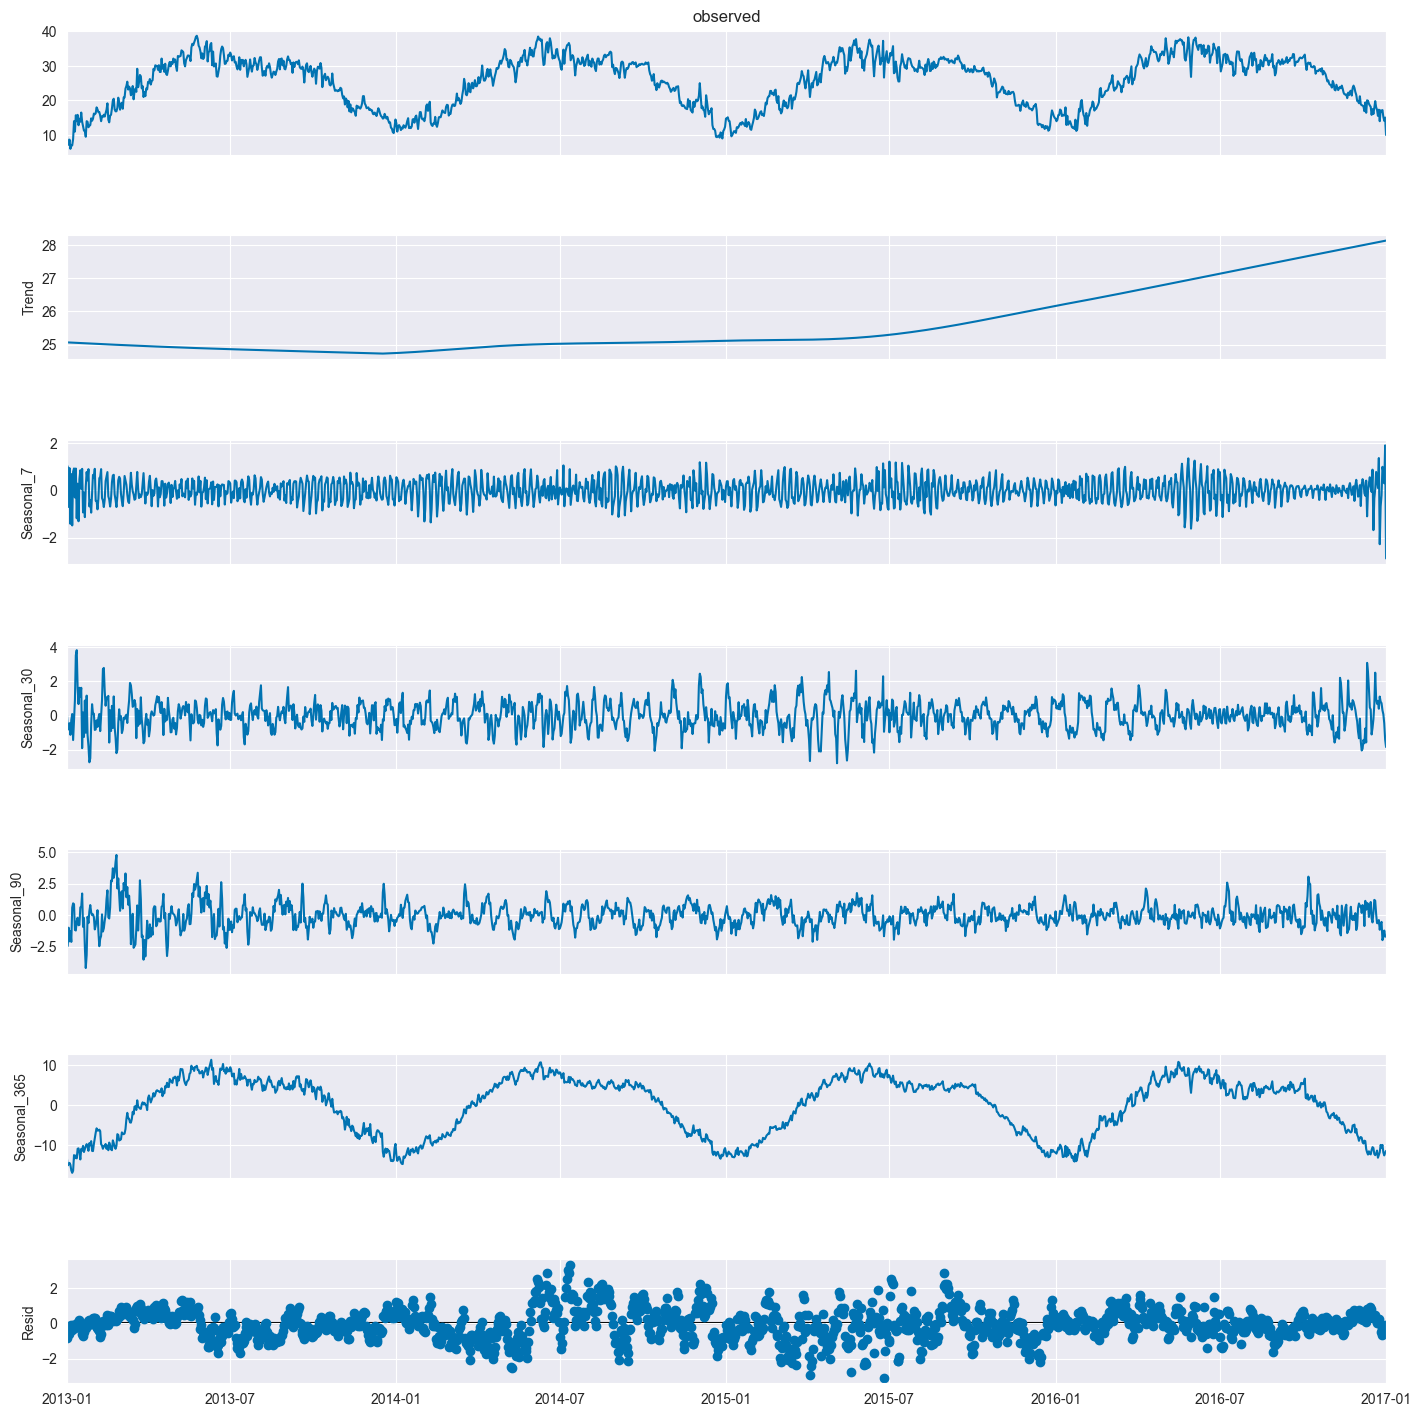

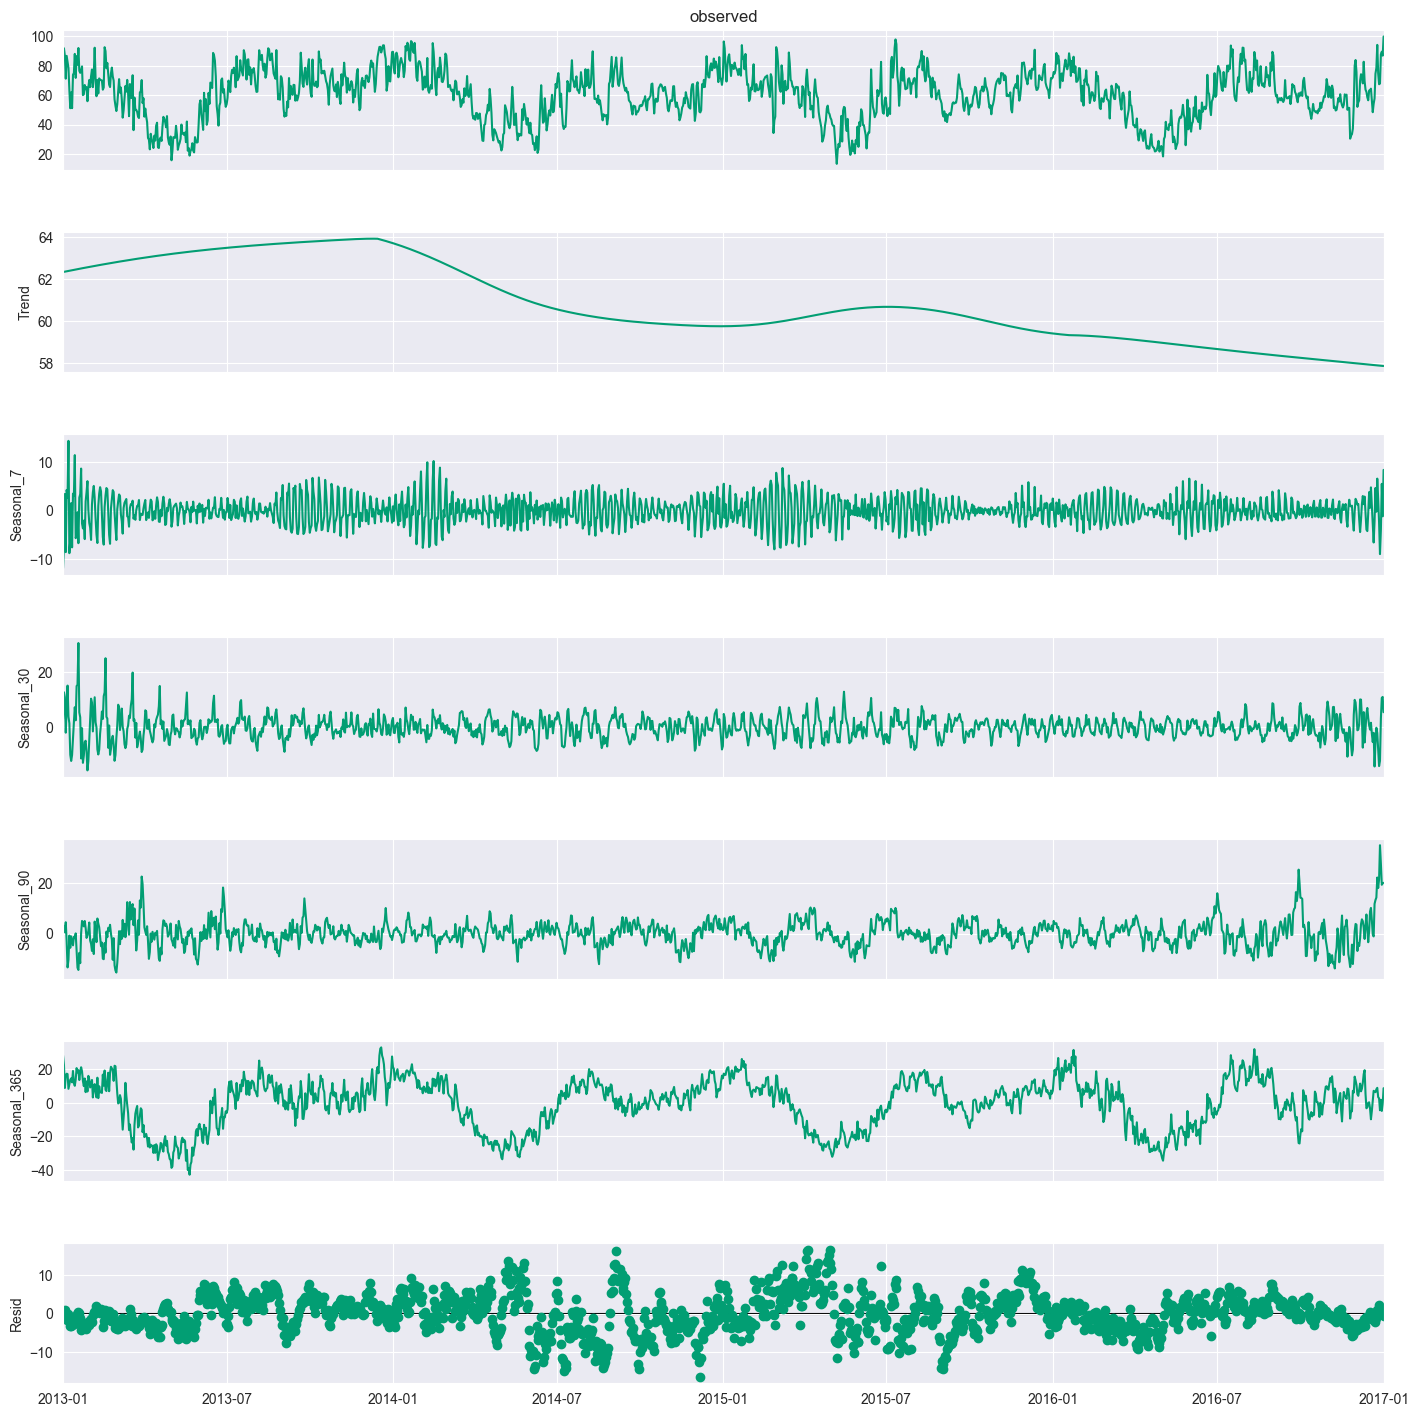

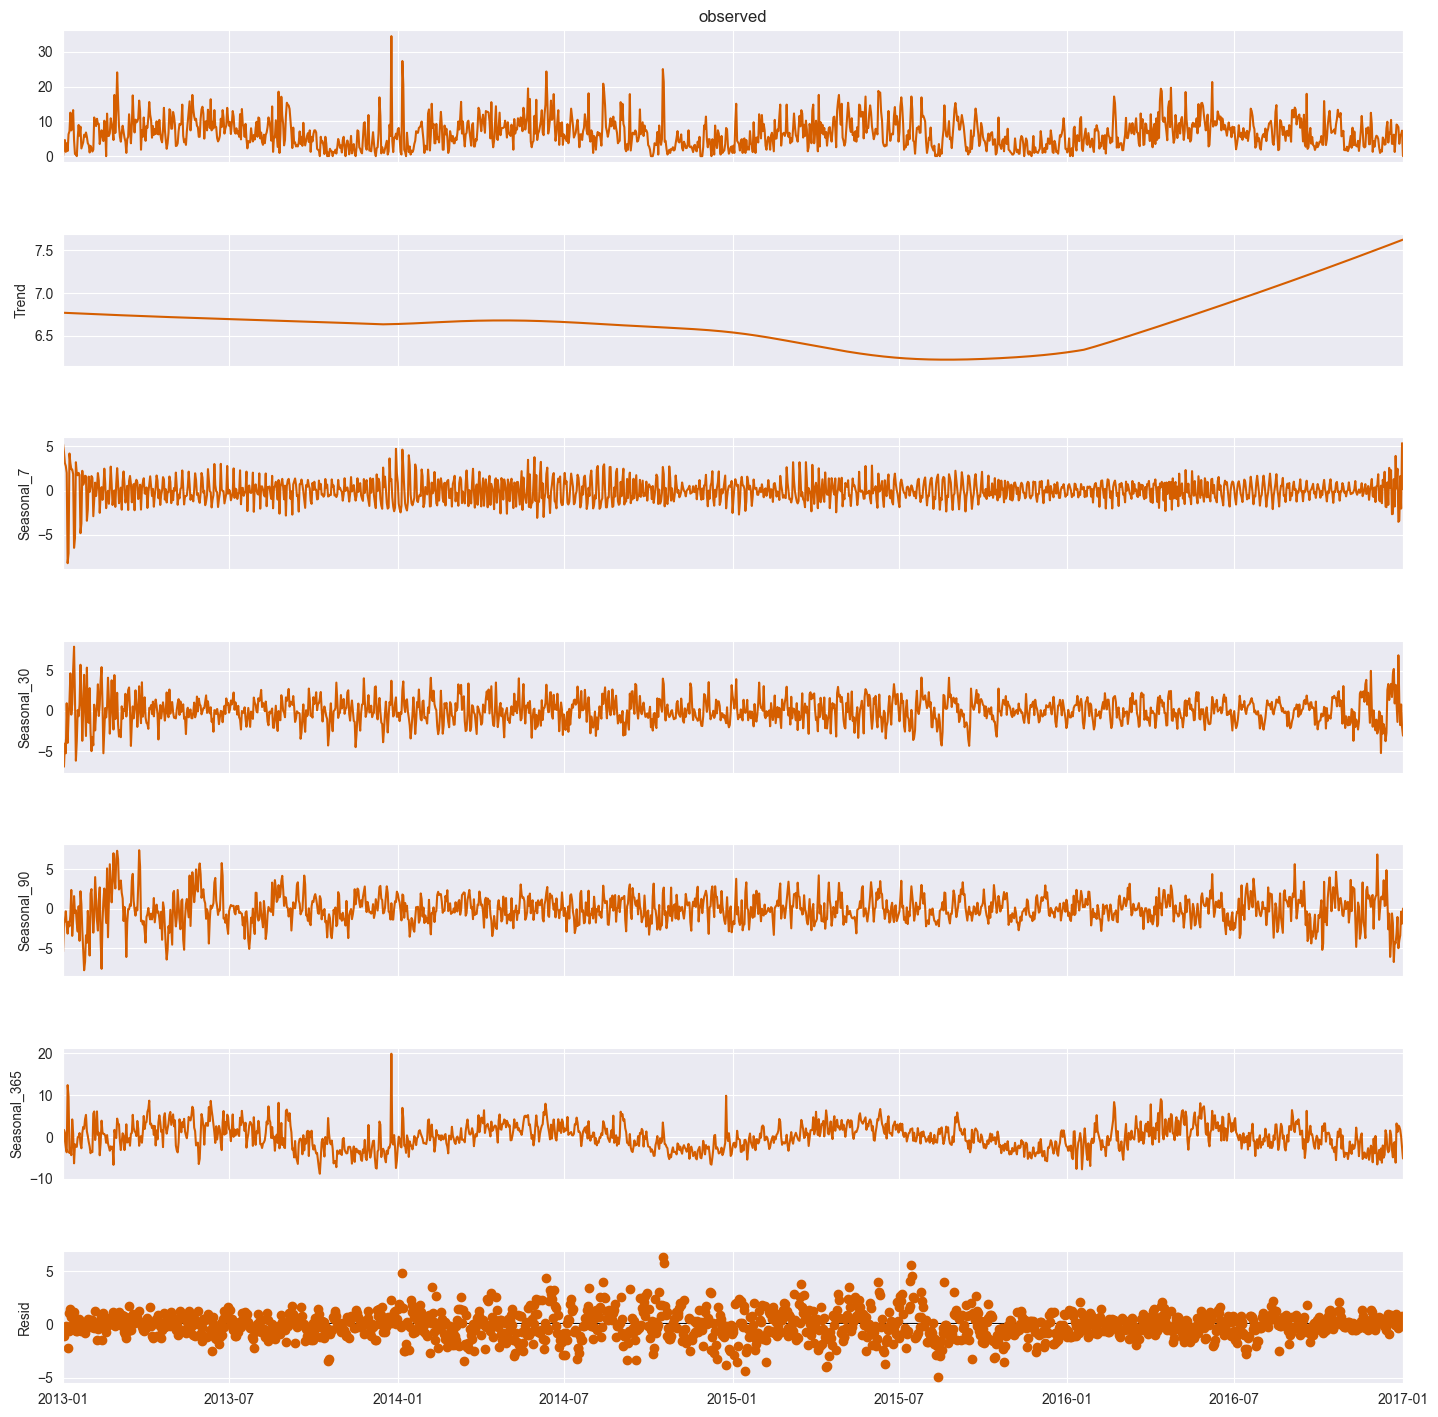

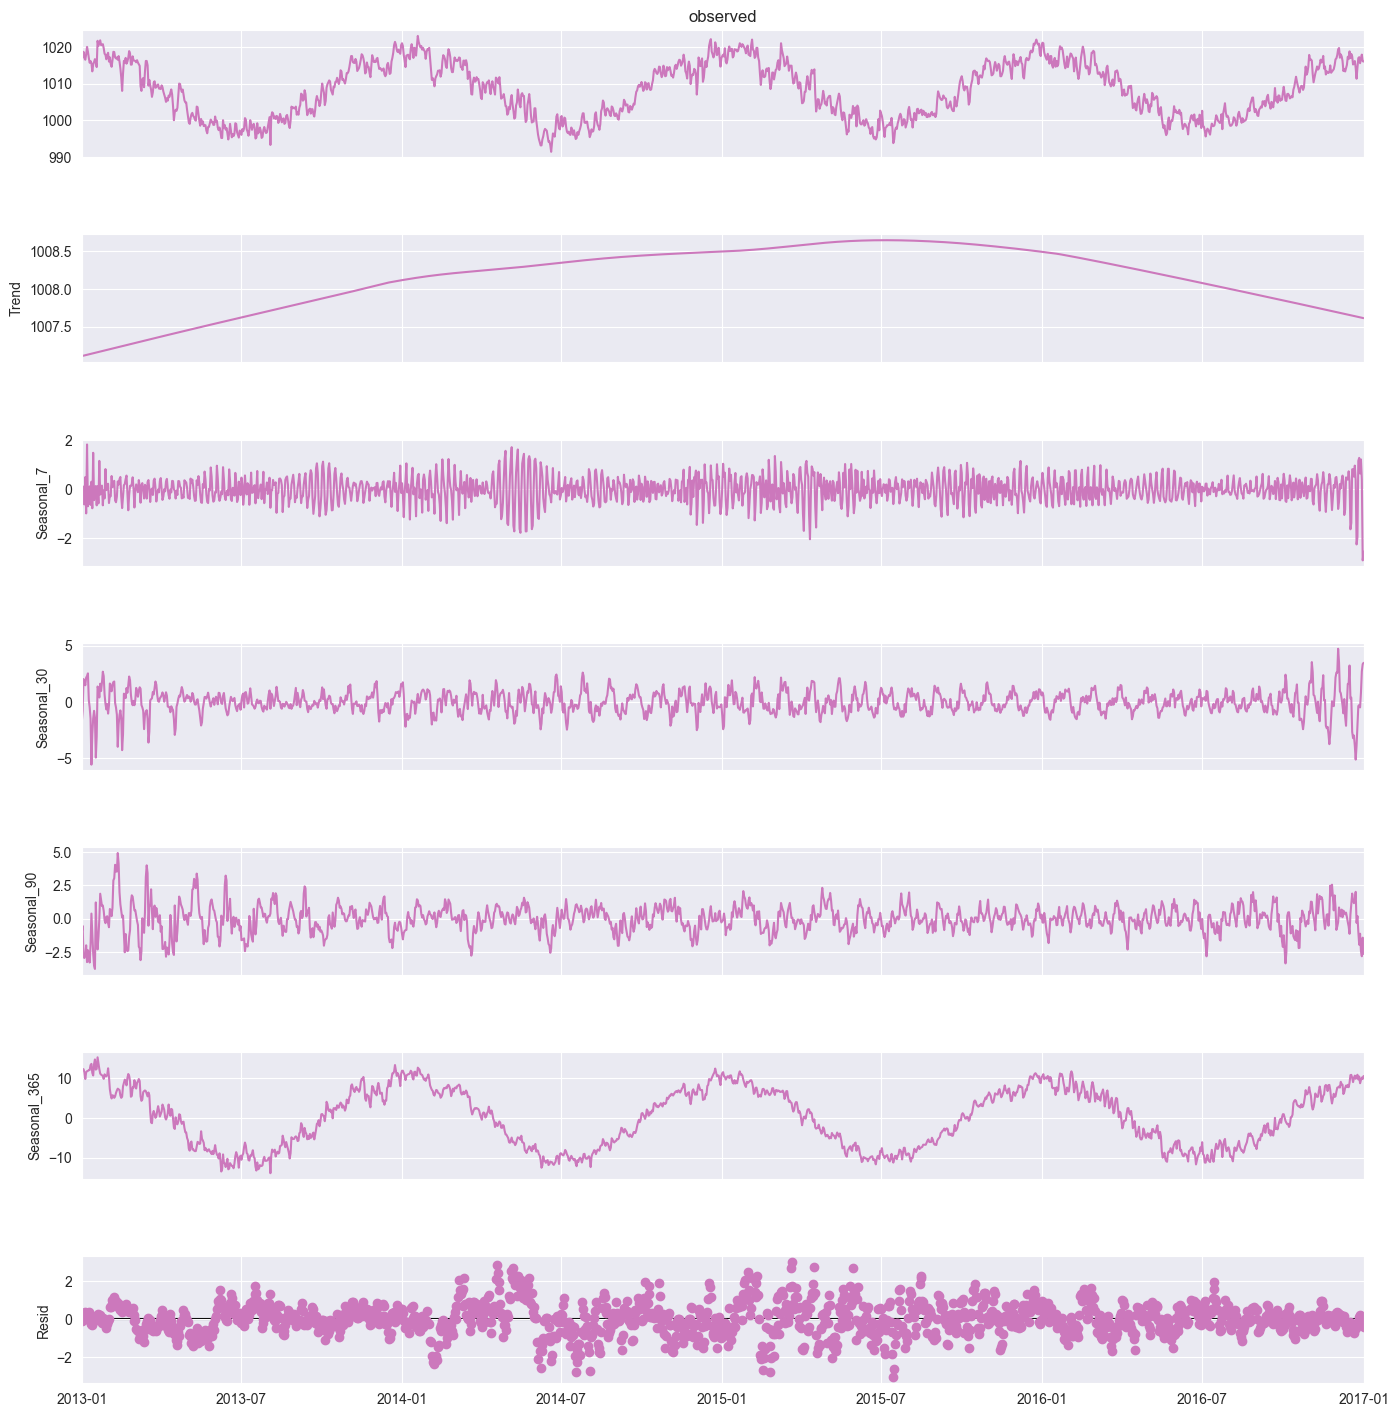

In [12]:

plt.figure(figsize=(14,12))
from statsmodels.tsa.seasonal import MSTL
for idx, col in enumerate(df.columns[1:]):
    column = df[col]
    column.index = df['date']
    res = MSTL(column, periods=(7, 30, 90, 365), windows=(7, 7, 7, 7), iterate = 10).fit()
    fig = res.plot()
    for ax in fig.axes:
        ax.lines[0].set_color(colors[idx])
    fig.set_size_inches((16, 16))
    plt.show()